<a href="https://colab.research.google.com/github/cr0wley-zz/Embeddings/blob/main/Glove.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
data = """
Marie Curie was one of the most accomplished scientists in history. Together with her husband, Pierre, she discovered radium, an element widely used for treating cancer, and studied uranium and other radioactive substances. Pierre and Marie’s amicable collaboration later helped to unlock the secrets of the atom.

Marie was born in 1867 in Warsaw, Poland, where her father was a professor of physics. At an early age, she displayed a brilliant mind and a blithe personality. Her great exuberance for learning prompted her to continue with her studies after high school. She became disgruntled, however, when she learned that the university in Warsaw was closed to women. Determined to receive a higher education, she defiantly left Poland and in 1891 entered the Sorbonne, a French university, where she earned her master’s degree and doctorate in physics.

Marie was fortunate to have studied at the Sorbonne with some of the greatest scientists of her day, one of whom was Pierre Curie. Marie and Pierre were married in 1895 and spent many productive years working together in the physics laboratory. A short time after they discovered radium, Pierre was killed by a horse-drawn wagon in 1906. Marie was stunned by this horrible misfortune and endured heartbreaking anguish. Despondently she recalled their close relationship and the joy that they had shared in scientific research. The fact that she had two young daughters to raise by herself greatly increased her distress.

Curie’s feeling of desolation finally began to fade when she was asked to succeed her husband as a physics professor at the Sorbonne. She was the first woman to be given a professorship at the world-famous university. In 1911 she received the Nobel Prize in chemistry for isolating radium. Although Marie Curie eventually suffered a fatal illness from her long exposure to radium, she never became disillusioned about her work. Regardless of the consequences, she had dedicated herself to science and to revealing the mysteries of the physical world.. 
"""

In [3]:
def word_processor(data):
  # Converts the data into tokens
  tokenized_text = tf.keras.preprocessing.text.text_to_word_sequence(data)
  tokenized_text_size = len(tokenized_text)
  # Creates a vocab of unique words
  vocab = sorted(set(tokenized_text))
  vocab_size = len(vocab)
  # Map the vocab words to individual indices
  vocab_to_ix = {c:ix for ix,c in enumerate(vocab)}
  # Map the indices to the words in vocab
  ix_to_vocab = np.array(vocab)
  # Convert the data into numbers
  text_as_int = np.array([vocab_to_ix[c] for c in tokenized_text])
  return vocab ,vocab_size, vocab_to_ix, ix_to_vocab, text_as_int

In [4]:
def compute_co_occurrence_matrix(corpus, window_size=1):
    """ Compute co-occurrence matrix for the given corpus and window_size (default of 4).

      Note: Each word in a document should be at the center of a window. Words near edges will have a smaller
            number of co-occurring words.
            
            For example, if we take the document "<START> All that glitters is not gold <END>" with window size of 4,
            "All" will co-occur with "<START>", "that", "glitters", "is", and "not".

      Params:
          corpus (list of list of strings): corpus of documents
          window_size (int): size of context window
      Return:
          M (a symmetric numpy matrix of shape (number of unique words in the corpus , number of unique words in the corpus)): 
              Co-occurence matrix of word counts. 
              The ordering of the words in the rows/columns should be the same as the ordering of the words given by the distinct_words function.
          word2Ind (dict): dictionary that maps word to index (i.e. row/column number) for matrix M.
    """
    vocab ,vocab_size, vocab_to_ix, ix_to_vocab, text_as_int  = word_processor(corpus)
    
    

    # ------------------
    # Write your implementation here.
    M = np.zeros((vocab_size, vocab_size))

    doc_len =  len(text_as_int)
    for current_idx in range(doc_len):
      left_boudary = max(current_idx-window_size, 0)
      right_boundary = min(current_idx+window_size+1, doc_len)
      outside_words = np.append(text_as_int[left_boudary:current_idx],text_as_int[current_idx+1:right_boundary])
      center_word = text_as_int[current_idx]
      
      
      for outside_word in outside_words:
          M[center_word, outside_word] += 1.0
      
      current_idx += 1
    # ------------------

    return M, vocab_to_ix, vocab_size, ix_to_vocab, text_as_int




In [5]:
co_occurance_matrix ,vocab_to_ix, vocab_size, ix_to_vocab, text_as_int   = compute_co_occurrence_matrix(data, 1)

In [6]:
probability_matrix = co_occurance_matrix/co_occurance_matrix.sum(axis = 0)

In [15]:
EMBEDDING_SIZE = 8
context_vector =  tf.Variable(np.random.rand(vocab_size, EMBEDDING_SIZE))
center_vector = tf.Variable(np.random.rand(vocab_size, EMBEDDING_SIZE))
bias_center = tf.Variable(np.random.rand(vocab_size, 1))
bias_context = tf.Variable(np.random.rand(vocab_size, 1))

In [13]:
def weighted_func(x):
  return (x/100)**(3/4) if x< 100 else 1

In [14]:
def train_step(indices, loss_list):
  """The training step

  Arguments:
    indices (list): The indices of the vocab in the window
  """
  
  with tf.GradientTape() as tape:
     cost = tf.Variable(0.0, dtype=tf.float64)
     for i in indices:
       for j in indices:
         prod = tf.tensordot(center_vector[i], context_vector[j], axes=1)
         bias = bias_center[i][0] + bias_context[j][0]
         cost = cost + weighted_func(co_occurance_matrix[i,j])*(prod + bias - tf.math.log(1+co_occurance_matrix[i,j]))**2
  
  loss_list.append(cost)
  grad = tape.gradient(cost, [context_vector, center_vector, bias_center, bias_context])
  opt.apply_gradients(zip(grad, [context_vector, center_vector, bias_center, bias_context]))

In [20]:
opt = tf.keras.optimizers.Adam()
loss_list = []
batch_size = 128
iterations = 20
for iter in tqdm(range(iterations)):
  indices = np.random.randint(low=0, high=vocab_size, size=batch_size)
  train_step(indices, loss_list)

 30%|███       | 6/20 [06:07<14:29, 62.12s/it]

KeyboardInterrupt: ignored

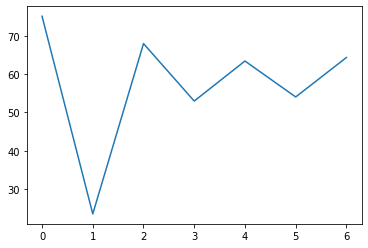

In [21]:
plt.plot(loss_list)

In [18]:
from sklearn.manifold import TSNE

center_vector_embedded = TSNE(n_components=2).fit_transform(center_vector.numpy())

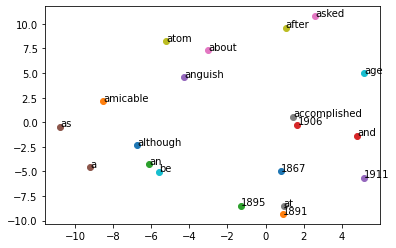

In [19]:
plt.figure()
count = 0
for i,j in center_vector_embedded[:20]:
  plt.scatter(i,j)
  plt.text( i+0.01, j+0.01, ix_to_vocab[count])
  count += 1
plt.show()  

In [37]:
ix_to_vocab

array(['also', 'aritra', 'bowl', 'can', 'coding', 'cricket', 'devjyoti',
       'eastern', 'football', 'hates', 'is', 'likes', 'loves', 'ludo',
       'movies', 'my', 'name', 'only', 'plays', 'sleeping', 'very',
       'watching', 'well', 'western', 'your'], dtype='<U8')

In [15]:
vocab_size

181